# Notes - Important !!!!
- go one more time through code - leave only sigmoid, maybe some other activation
- check whether decriptive stats arecalulated as should - so that it does not use future observations
- do separation into test and train dataset - split by time - separator class maybe
- figure out how to do hyperparameter selection(nodes, activation, layers)
    

### Setup

In [1]:
# load packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [3]:
# classes and functions from 'util'
from util.data_load import returns_load
from util.GarchEstimator import GarchEstimator
from util.DescStat import DescStat
from util.Standardizer import Standardizer
from util.TrainTestSplitter import Splitter
# from util.ANN_core import NeuralNetwork

In [4]:
# setting seed for reproducibility
np.random.seed(1995)

In [5]:
# Variables used in code
start_dt = '2000-01-01'
end_dt = '2020-03-01'
ticker = 'MSFT' 
interval = '1d'
garch_init = {
    'alpha' : 0.7,
    'beta1' : 0.3,
    'beta2' : 0.1,
    'omega1' : 0.01,
    'omega2' : 0.01,
    'omega3' : 0.01
}

### Data Load

In [6]:
ret_data = returns_load(ticker=ticker,
                    interval=interval,
                    start_dt=start_dt,
                    end_dt=end_dt)

[*********************100%***********************]  1 of 1 completed


### Garch estimation

In [7]:
garch =  GarchEstimator(theta_init = garch_init)

In [ ]:
ret_data['garch'] = garch.fit_data(
    method='GARCH',
    data_estimate=ret_data['return']*100,
    data_fit=ret_data['return']*100
    
)
print(garch.get_estimates(coef=True, llik=True))

In [ ]:
# Plot Garch vs Observed
x = ret_data['dt']
y1 = ret_data['return']*100
y2 = ret_data['garch']
plt.plot(x, y1)
plt.plot(x, y2)
plt.show()

In [91]:
### Addition of Descriptive Features Calculated from returns

In [10]:
desc_obj = DescStat(data=ret_data['return']*100)

In [27]:
ret_data_enriched = (
    pd.DataFrame({
            'dt': ret_data['dt'],
            'return100' : ret_data['return']*100,
            'garch': ret_data['garch'],
            'mean5_return100': desc_obj.calc_mean(window=5, fill_initial='first_constant'),
            'var5_return100': desc_obj.calc_var(window=5, fill_initial='first_constant'),
    })
    .set_index('dt')
)
    

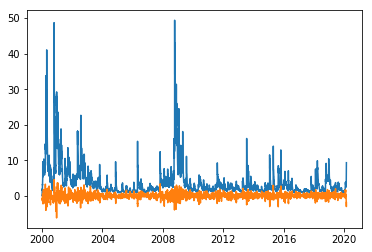

In [29]:

y1 = ret_data_enriched['return100']
y2 = ret_data_enriched['garch']
y3 = ret_data_enriched['mean5_return100']
y4 = ret_data_enriched['var5_return100']
# plt.plot(y1)
plt.plot(y2)
plt.plot(y3)
# plt.plot(y4)
plt.show()

In [30]:
ret_data_enriched.head()

,return100,garch,mean5_return100,var5_return100
dt,,,,
2000-01-03,-0.160600,0.100000,-0.905444,5.344588
2000-01-04,-3.378016,0.100000,-0.905444,5.344588
2000-01-05,1.054384,0.100000,-0.905444,5.344588
2000-01-06,-3.349808,1.359696,-0.905444,5.344588
2000-01-07,1.306818,1.589353,-0.905444,5.344588


In [31]:
ret_data_enriched.shape

(5071, 4)

In [32]:
ret_data_enriched.dropna(inplace=True)
ret_data_enriched.shape

(5071, 4)

# Code from Internet, just for comparison - soon to be deleted

In [16]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_der(x):
    return sigmoid(x)*(1-sigmoid(x))

def linear(x):
    return(x)

def linear_der(x):
    return np.ones(x.shape)

def lLik(obs_val, sigma_pred):

    LLik = -(1/2) * np.log(2 * np.pi) - (1/2) * np.log(sigma_pred ** 2) - (1/2) * ((obs_val** 2) / sigma_pred ** 2)

    return LLik	

def lLik_der(obs_val, sigma_pred):
    
    LLik_der = - 1 / sigma_pred + (1 / sigma_pred ** 3) * (obs_val ** 2)
    
    return LLik_der

In [142]:
np.random.seed(42)
weights = np.random.rand(3,1)
bias = np.random.rand(1,1)
lr = 0.00001

In [143]:
feature_set = ret_data_enriched.iloc[:, 2:5]
labels = ret_data_enriched.iloc[:, 1:2]

In [144]:
for epoch in range(100):
    inputs = feature_set

    # feedforward step1
    XW = np.dot(feature_set, weights) + bias

    #feedforward step2
    z = linear(XW)

    # backpropagation step 1
#     error = z - labels
    error = lLik(labels, z)
    error_der = lLik_der(labels, z)
    print(error.sum())

    # backpropagation step 2
    dcost_dpred = error_der
    dpred_dz = linear_der(z)

    z_delta = dcost_dpred * dpred_dz

    inputs = feature_set.T
    weights += lr * np.dot(inputs, z_delta)
    bias += lr * np.dot(np.ones((1, z_delta.shape[0])),  z_delta)
    
print(weights)
print(bias)

return100   -11132.755247
dtype: float64
return100   -11012.270826
dtype: float64
return100   -10922.628886
dtype: float64
return100   -10846.690167
dtype: float64
return100   -10770.648132
dtype: float64
return100   -10694.274198
dtype: float64
return100   -10617.708006
dtype: float64
return100   -10541.115945
dtype: float64
return100   -10464.679808
dtype: float64
return100   -10388.592192
dtype: float64
return100   -10313.053145
dtype: float64
return100   -10238.26599
dtype: float64
return100   -10164.432964
dtype: float64
return100   -10091.75099
dtype: float64
return100   -10020.40797
dtype: float64
return100   -9950.579911
dtype: float64
return100   -9882.429
dtype: float64
return100   -9816.102565
dtype: float64
return100   -9751.732685
dtype: float64
return100   -9689.436159
dtype: float64
return100   -9629.314542
dtype: float64
return100   -9571.454049
dtype: float64
return100   -9515.925253
dtype: float64
return100   -9462.782598
dtype: float64
return100   -9412.06387
dtype: 

### Train Test Separation

In [89]:
Splitter = Splitter(train_part=0.7)

In [90]:
[train_data, test_data] = Splitter.split(dataset = ret_data_enriched)

### Standardize the data

In [176]:
# initiate standardizer 
Standardizer_train = Standardizer(
    demean=True,
    rescale=True,
    skipna=True
)

In [177]:
# standardize all but first column where the returns are
train_data_standard = (
    train_data
        .drop('return100', axis=1)
        .apply(
            func=Standardizer_train.perform_calc,
            axis=0,
            result_type='broadcast'
        )
        .join(train_data[['return100']])
)

# Content of ANN_core - for easier manipulation here and then at the end of session copied to separate .py file

In [156]:
# =============================================================================
# define sigmoid function
# =============================================================================

def sigmoid(x):
    
    return 1/(1+ np.exp(-x))

# =============================================================================
# define sigmoid derivative function
# =============================================================================

def sigmoid_der(x):
    
#     return sigmoid(x) * (1 - sigmoid(x))
    return x * (1 - x)

# =============================================================================
# define log likelihood function
# =============================================================================

def lLik(obs_val, sigma_pred):

    LLik = -(1/2) * np.log(2 * np.pi) - (1/2) * np.log(sigma_pred ** 2) - (1/2) * ((obs_val** 2) / sigma_pred ** 2)

    return LLik	

# =============================================================================
# define derivation of log likelihood
# =============================================================================

def lLik_der(obs_val, sigma_pred):
    
    LLik_der = - 1 / sigma_pred + (1 / sigma_pred ** 3) * (obs_val ** 2)
    
    return LLik_der

# =============================================================================
# define squared errors
# =============================================================================

def square_error(obs_val, obs_pred):
    
    return (obs_val - obs_pred) ** 2

# =============================================================================
# define first derivative of squared errors
# =============================================================================
    
#in this case should be multiplied by -1 since with respect to obs_pred, but then 
#change in weights and biases is not += but -=
def square_error_der(obs_val, obs_pred):
    
    return  (obs_val - obs_pred)

# =============================================================================
# define linear function for case when only one layer
# =============================================================================
def linear(x):
    
    return x

# =============================================================================
# define derivative of linear 
# =============================================================================
def linear_der(x):
        
    return np.ones(x.shape)
# =============================================================================
# class object NeuralNetwork
# =============================================================================
    
class NeuralNetwork:

    def __init__(self, x, y, obj_fun = square_error, node_fun = linear,
                 hidden_layer = 1, step_rate = 0.001, bias = False, num_nodes = [1,0]):
        
        self.nodes1     = num_nodes[0]
        
        self.nodes2     = num_nodes[1]
        
        if obj_fun == square_error :
            
            self.obj_fun = square_error
            
            self.obj_fun_der = square_error_der
        
        elif obj_fun == lLik :
            
            self.obj_fun = lLik
            
            self.obj_fun_der = lLik_der
            
        else :
            
            print('set objective function to either squared errors or log-likelihood')
        
        self.input      = x
        
        self.y          = y

        self.output     = np.ones(self.y.shape)
        
        self.step_rate = step_rate
        
        self.bias = bias * 1
        
        if hidden_layer == 0 :
            
            self.weights_out = self.weights_hidden = np.ones([1,1])
            
            self.weights_input = np.random.rand(self.input.shape[1], 1)
            
            self.bias_out = self.bias_hidden = self.bias_input = np.zeros([1,1])
            
            self.node1_fun = linear
            
            self.node1_fun_der = linear_der
            
            self.node2_fun = linear
            
            self.node2_fun_der = linear_der
        
        elif hidden_layer == 1 :
            
            self.weights_out = np.ones([1,1])
            
            self.weights_hidden = np.random.rand(self.nodes1, 1)
            
            self.weights_input = np.random.rand(self.input.shape[1], self.nodes1)
            
            self.bias_out = self.bias_hidden = np.zeros([1,1])
            
            self.bias_input = np.zeros([1, self.nodes1])
            
            self.node1_fun = node_fun
            
            if node_fun == linear :
                
                self.node1_fun_der = linear_der
                
            elif node_fun == sigmoid :
                
                self.node1_fun_der = sigmoid_der
            
            self.node2_fun = linear
            
            self.node2_fun_der = linear_der
            
        elif hidden_layer == 2 :
            
            self.weights_out = np.random.rand(self.nodes2, 1)
            
            self.weights_hidden = np.random.rand(self.nodes1, self.nodes2)
            
            self.weights_input = np.random.rand(self.input.shape[1], self.nodes1)
            
            self.bias_out = np.zeros([1,1])
            
            self.bias_hidden = np.zeros([1, self.nodes2])
            
            self.bias_input = np.zeros([1, self.nodes1])
            
            self.node1_fun = self.node2_fun = node_fun
            
            if node_fun == linear :
                
                self.node1_fun_der = self.node2_fun_der = linear_der
                
            elif node_fun == sigmoid :
                
                self.node1_fun_der = self.node2_fun_der = sigmoid_der
                
            else:
                
                print('set the node function to either sigmoid or linear')
                
        else:
            
            print('set number of hidden layers to 0, 1 or 2')
            
    def feedforward(self):

        self.layer1 = self.node1_fun(np.dot(self.input, self.weights_input) + self.bias_input)
        
        self.layer2 = self.node2_fun(np.dot(self.layer1, self.weights_hidden) + self.bias_hidden)
        
        self.output = np.dot(self.layer2, self.weights_out) + self.bias_out
        
    def backprop(self):
        
        #calculate errors and partial derivatives
        
        error_out = self.obj_fun_der(self.y, self.output)
        
#         print(error_out.head())
        
        d_weights_out = np.dot(self.layer2.T, error_out) 
        
#         print(d_weights_out)
        
        error_hidden = np.dot(error_out, self.weights_out.T) * self.node2_fun_der(self.layer2) # this is derivative in terms of f(x) maybe should change to derivative in terms of x, then it needs to be layer1*weights_hidden
        
#         print(error_hidden[1:5])
        
        d_weights_hidden = np.dot(self.layer1.T, error_hidden) 
        
#         print(d_weights_hidden)
        
        error_input = np.dot(error_hidden, self.weights_hidden.T) * self.node1_fun_der(self.layer1)
        
#         print(error_input[1:5])
        
        d_weights_input = np.dot(self.input.T, error_input)
        
#         print(d_weights_input)
        
        d_bias_out = np.dot(np.ones(self.output.shape[0]), error_out) 
        
        d_bias_hidden = np.dot(np.ones(self.layer2.shape[0]), error_hidden)
        
        d_bias_input = np.dot(np.ones(self.input.shape[0]), error_input)
        
        #update weights and biases
        
        self.weights_out += d_weights_out * self.step_rate * (self.nodes2 > 0)
        
        self.weights_hidden += d_weights_hidden * self.step_rate * (self.nodes1 > 0) 
        
        self.weights_input += d_weights_input * self.step_rate
        
        self.bias_out += d_bias_out * self.step_rate * self.bias * (self.nodes2 > 0)
        
        self.bias_hidden += d_bias_hidden * self.step_rate * self.bias * (self.nodes1 > 0)
        
        self.bias_input += d_bias_input * self.step_rate * self.bias
    
    def cost(self, new_input = None, new_y = None):
        # check if different input specified
        if new_input is None and new_y is None: 
            # if not - get the cost from training
            return np.sum(self.obj_fun(self.y, self.output))
        else:
            # if yes - get new prediction 
            layer1 = self.node1_fun(np.dot(new_input, self.weights_input) + self.bias_input)
            layer2 = self.node2_fun(np.dot(layer1, self.weights_hidden) + self.bias_hidden)
            predicted_output = np.dot(layer2, self.weights_out) + self.bias_out

            return np.sum(self.obj_fun(new_y, predicted_output))
    
    def predict(self, new_input = None):
        # check if different input specified
        if new_input is None: 
            # if not - get the output from training
            return self.output
        else:
            # if yes - get new prediction 
            layer1 = self.node1_fun(np.dot(new_input, self.weights_input) + self.bias_input)
            layer2 = self.node2_fun(np.dot(layer1, self.weights_hidden) + self.bias_hidden)
            predicted_output = np.dot(layer2, self.weights_out) + self.bias_out

            return predicted_output
        
    
    # this has been here for debugging
    def get_observed(self):
        return self.y
    def get_layer1(self):
        return self.layer1
    def get_layer2(self):
        return self.layer2
    def get_weights(self):
        return [self.weights_input, self.weights_hidden, self.weights_out]
    def get_input(self): 
        return self.input


### NN Estimation

In [157]:
NN_obj = NeuralNetwork(
    x=train_data_standard.drop('return100', axis=1),
    y=train_data_standard[['return100']],
    obj_fun=lLik,
    hidden_layer=1,
    node_fun=sigmoid,
    num_nodes=[4,0],
    step_rate=0.0001
)

In [158]:
NN_obj.feedforward()
for i in range(5000) :
        NN_obj.backprop()
        NN_obj.feedforward()
        print(NN_obj.cost()[0])

return100   -6941.794499
dtype: float64
return100   -6896.214406
dtype: float64
return100   -6863.029374
dtype: float64
return100   -6836.642281
dtype: float64
return100   -6814.563588
dtype: float64
return100   -6795.513829
dtype: float64
return100   -6778.760016
dtype: float64
return100   -6763.842047
dtype: float64
return100   -6750.446928
dtype: float64
return100   -6738.346351
dtype: float64
return100   -6727.363949
dtype: float64
return100   -6717.357322
dtype: float64
return100   -6708.207793
dtype: float64
return100   -6699.814315
dtype: float64
return100   -6692.089663
dtype: float64
return100   -6684.957916
dtype: float64
return100   -6678.352676
dtype: float64
return100   -6672.215717
dtype: float64
return100   -6666.495914
dtype: float64
return100   -6661.148338
dtype: float64
return100   -6656.133494
dtype: float64
return100   -6651.416645
dtype: float64
return100   -6646.967228
dtype: float64
return100   -6642.758336
dtype: float64
return100   -6638.766266
dtype: float64


return100   -6451.534243
dtype: float64
return100   -6451.128097
dtype: float64
return100   -6450.723517
dtype: float64
return100   -6450.320487
dtype: float64
return100   -6449.918986
dtype: float64
return100   -6449.518997
dtype: float64
return100   -6449.120501
dtype: float64
return100   -6448.723481
dtype: float64
return100   -6448.32792
dtype: float64
return100   -6447.933801
dtype: float64
return100   -6447.541107
dtype: float64
return100   -6447.149823
dtype: float64
return100   -6446.759931
dtype: float64
return100   -6446.371417
dtype: float64
return100   -6445.984265
dtype: float64
return100   -6445.59846
dtype: float64
return100   -6445.213988
dtype: float64
return100   -6444.830834
dtype: float64
return100   -6444.448984
dtype: float64
return100   -6444.068424
dtype: float64
return100   -6443.689141
dtype: float64
return100   -6443.311121
dtype: float64
return100   -6442.934351
dtype: float64
return100   -6442.558818
dtype: float64
return100   -6442.184511
dtype: float64
re

dtype: float64
return100   -6385.018308
dtype: float64
return100   -6384.751312
dtype: float64
return100   -6384.484284
dtype: float64
return100   -6384.217217
dtype: float64
return100   -6383.950107
dtype: float64
return100   -6383.682947
dtype: float64
return100   -6383.415731
dtype: float64
return100   -6383.148454
dtype: float64
return100   -6382.88111
dtype: float64
return100   -6382.613692
dtype: float64
return100   -6382.346197
dtype: float64
return100   -6382.078618
dtype: float64
return100   -6381.81095
dtype: float64
return100   -6381.543189
dtype: float64
return100   -6381.275328
dtype: float64
return100   -6381.007363
dtype: float64
return100   -6380.73929
dtype: float64
return100   -6380.471103
dtype: float64
return100   -6380.202799
dtype: float64
return100   -6379.934371
dtype: float64
return100   -6379.665818
dtype: float64
return100   -6379.397133
dtype: float64
return100   -6379.128313
dtype: float64
return100   -6378.859354
dtype: float64
return100   -6378.590253
dty

return100   -6329.044957
dtype: float64
return100   -6328.793579
dtype: float64
return100   -6328.542604
dtype: float64
return100   -6328.292034
dtype: float64
return100   -6328.041874
dtype: float64
return100   -6327.792129
dtype: float64
return100   -6327.542802
dtype: float64
return100   -6327.293897
dtype: float64
return100   -6327.04542
dtype: float64
return100   -6326.797373
dtype: float64
return100   -6326.549762
dtype: float64
return100   -6326.30259
dtype: float64
return100   -6326.055863
dtype: float64
return100   -6325.809584
dtype: float64
return100   -6325.563758
dtype: float64
return100   -6325.31839
dtype: float64
return100   -6325.073484
dtype: float64
return100   -6324.829044
dtype: float64
return100   -6324.585075
dtype: float64
return100   -6324.341582
dtype: float64
return100   -6324.09857
dtype: float64
return100   -6323.856042
dtype: float64
return100   -6323.614003
dtype: float64
return100   -6323.372458
dtype: float64
return100   -6323.131412
dtype: float64
retu

dtype: float64
return100   -6289.527918
dtype: float64
return100   -6289.417279
dtype: float64
return100   -6289.307285
dtype: float64
return100   -6289.197936
dtype: float64
return100   -6289.089228
dtype: float64
return100   -6288.98116
dtype: float64
return100   -6288.873729
dtype: float64
return100   -6288.766933
dtype: float64
return100   -6288.660769
dtype: float64
return100   -6288.555237
dtype: float64
return100   -6288.450332
dtype: float64
return100   -6288.346054
dtype: float64
return100   -6288.242399
dtype: float64
return100   -6288.139365
dtype: float64
return100   -6288.036951
dtype: float64
return100   -6287.935153
dtype: float64
return100   -6287.833969
dtype: float64
return100   -6287.733398
dtype: float64
return100   -6287.633435
dtype: float64
return100   -6287.53408
dtype: float64
return100   -6287.43533
dtype: float64
return100   -6287.337182
dtype: float64
return100   -6287.239634
dtype: float64
return100   -6287.142684
dtype: float64
return100   -6287.046328
dty

dtype: float64
return100   -6276.867606
dtype: float64
return100   -6276.839294
dtype: float64
return100   -6276.811166
dtype: float64
return100   -6276.783222
dtype: float64
return100   -6276.755459
dtype: float64
return100   -6276.727877
dtype: float64
return100   -6276.700473
dtype: float64
return100   -6276.673247
dtype: float64
return100   -6276.646197
dtype: float64
return100   -6276.619321
dtype: float64
return100   -6276.592618
dtype: float64
return100   -6276.566087
dtype: float64
return100   -6276.539726
dtype: float64
return100   -6276.513534
dtype: float64
return100   -6276.48751
dtype: float64
return100   -6276.461652
dtype: float64
return100   -6276.435958
dtype: float64
return100   -6276.410429
dtype: float64
return100   -6276.385061
dtype: float64
return100   -6276.359854
dtype: float64
return100   -6276.334807
dtype: float64
return100   -6276.309918
dtype: float64
return100   -6276.285186
dtype: float64
return100   -6276.260609
dtype: float64
return100   -6276.236187
d

return100   -6273.356206
dtype: float64
return100   -6273.346013
dtype: float64
return100   -6273.33585
dtype: float64
return100   -6273.325715
dtype: float64
return100   -6273.315607
dtype: float64
return100   -6273.305528
dtype: float64
return100   -6273.295476
dtype: float64
return100   -6273.285452
dtype: float64
return100   -6273.275455
dtype: float64
return100   -6273.265484
dtype: float64
return100   -6273.255541
dtype: float64
return100   -6273.245623
dtype: float64
return100   -6273.235732
dtype: float64
return100   -6273.225867
dtype: float64
return100   -6273.216027
dtype: float64
return100   -6273.206212
dtype: float64
return100   -6273.196423
dtype: float64
return100   -6273.186659
dtype: float64
return100   -6273.17692
dtype: float64
return100   -6273.167205
dtype: float64
return100   -6273.157514
dtype: float64
return100   -6273.147847
dtype: float64
return100   -6273.138204
dtype: float64
return100   -6273.128585
dtype: float64
return100   -6273.118989
dtype: float64
re

dtype: float64
return100   -6271.605169
dtype: float64
return100   -6271.597675
dtype: float64
return100   -6271.590187
dtype: float64
return100   -6271.582703
dtype: float64
return100   -6271.575223
dtype: float64
return100   -6271.567748
dtype: float64
return100   -6271.560278
dtype: float64
return100   -6271.552813
dtype: float64
return100   -6271.545351
dtype: float64
return100   -6271.537895
dtype: float64
return100   -6271.530442
dtype: float64
return100   -6271.522994
dtype: float64
return100   -6271.515551
dtype: float64
return100   -6271.508112
dtype: float64
return100   -6271.500677
dtype: float64
return100   -6271.493246
dtype: float64
return100   -6271.485819
dtype: float64
return100   -6271.478397
dtype: float64
return100   -6271.470979
dtype: float64
return100   -6271.463565
dtype: float64
return100   -6271.456155
dtype: float64
return100   -6271.448749
dtype: float64
return100   -6271.441347
dtype: float64
return100   -6271.433949
dtype: float64
return100   -6271.426556


dtype: float64
return100   -6270.131969
dtype: float64
return100   -6270.124974
dtype: float64
return100   -6270.11798
dtype: float64
return100   -6270.110986
dtype: float64
return100   -6270.103994
dtype: float64
return100   -6270.097002
dtype: float64
return100   -6270.090012
dtype: float64
return100   -6270.083023
dtype: float64
return100   -6270.076035
dtype: float64
return100   -6270.069047
dtype: float64
return100   -6270.062061
dtype: float64
return100   -6270.055076
dtype: float64
return100   -6270.048092
dtype: float64
return100   -6270.041108
dtype: float64
return100   -6270.034126
dtype: float64
return100   -6270.027145
dtype: float64
return100   -6270.020164
dtype: float64
return100   -6270.013185
dtype: float64
return100   -6270.006206
dtype: float64
return100   -6269.999229
dtype: float64
return100   -6269.992252
dtype: float64
return100   -6269.985276
dtype: float64
return100   -6269.978302
dtype: float64
return100   -6269.971328
dtype: float64
return100   -6269.964355
d

return100   -6268.641898
dtype: float64
return100   -6268.634992
dtype: float64
return100   -6268.628086
dtype: float64
return100   -6268.62118
dtype: float64
return100   -6268.614273
dtype: float64
return100   -6268.607367
dtype: float64
return100   -6268.60046
dtype: float64
return100   -6268.593554
dtype: float64
return100   -6268.586647
dtype: float64
return100   -6268.57974
dtype: float64
return100   -6268.572833
dtype: float64
return100   -6268.565925
dtype: float64
return100   -6268.559018
dtype: float64
return100   -6268.55211
dtype: float64
return100   -6268.545203
dtype: float64
return100   -6268.538295
dtype: float64
return100   -6268.531387
dtype: float64
return100   -6268.524479
dtype: float64
return100   -6268.51757
dtype: float64
return100   -6268.510662
dtype: float64
return100   -6268.503753
dtype: float64
return100   -6268.496845
dtype: float64
return100   -6268.489936
dtype: float64
return100   -6268.483026
dtype: float64
return100   -6268.476117
dtype: float64
retur

dtype: float64
return100   -6267.169852
dtype: float64
return100   -6267.162845
dtype: float64
return100   -6267.155837
dtype: float64
return100   -6267.148829
dtype: float64
return100   -6267.141819
dtype: float64
return100   -6267.134809
dtype: float64
return100   -6267.127798
dtype: float64
return100   -6267.120786
dtype: float64
return100   -6267.113773
dtype: float64
return100   -6267.10676
dtype: float64
return100   -6267.099745
dtype: float64
return100   -6267.09273
dtype: float64
return100   -6267.085714
dtype: float64
return100   -6267.078697
dtype: float64
return100   -6267.071679
dtype: float64
return100   -6267.06466
dtype: float64
return100   -6267.05764
dtype: float64
return100   -6267.05062
dtype: float64
return100   -6267.043598
dtype: float64
return100   -6267.036576
dtype: float64
return100   -6267.029553
dtype: float64
return100   -6267.022529
dtype: float64
return100   -6267.015504
dtype: float64
return100   -6267.008478
dtype: float64
return100   -6267.001452
dtype

dtype: float64
return100   -6265.711765
dtype: float64
return100   -6265.704522
dtype: float64
return100   -6265.697277
dtype: float64
return100   -6265.690031
dtype: float64
return100   -6265.682783
dtype: float64
return100   -6265.675534
dtype: float64
return100   -6265.668283
dtype: float64
return100   -6265.661031
dtype: float64
return100   -6265.653777
dtype: float64
return100   -6265.646521
dtype: float64
return100   -6265.639264
dtype: float64
return100   -6265.632006
dtype: float64
return100   -6265.624745
dtype: float64
return100   -6265.617484
dtype: float64
return100   -6265.61022
dtype: float64
return100   -6265.602955
dtype: float64
return100   -6265.595689
dtype: float64
return100   -6265.588421
dtype: float64
return100   -6265.581151
dtype: float64
return100   -6265.57388
dtype: float64
return100   -6265.566607
dtype: float64
return100   -6265.559332
dtype: float64
return100   -6265.552056
dtype: float64
return100   -6265.544778
dtype: float64
return100   -6265.537499
dt

dtype: float64
return100   -6264.118507
dtype: float64
return100   -6264.11081
dtype: float64
return100   -6264.10311
dtype: float64
return100   -6264.095408
dtype: float64
return100   -6264.087702
dtype: float64
return100   -6264.079994
dtype: float64
return100   -6264.072282
dtype: float64
return100   -6264.064568
dtype: float64
return100   -6264.05685
dtype: float64
return100   -6264.04913
dtype: float64
return100   -6264.041407
dtype: float64
return100   -6264.033681
dtype: float64
return100   -6264.025952
dtype: float64
return100   -6264.01822
dtype: float64
return100   -6264.010485
dtype: float64
return100   -6264.002747
dtype: float64
return100   -6263.995006
dtype: float64
return100   -6263.987262
dtype: float64
return100   -6263.979514
dtype: float64
return100   -6263.971764
dtype: float64
return100   -6263.964011
dtype: float64
return100   -6263.956255
dtype: float64
return100   -6263.948496
dtype: float64
return100   -6263.940733
dtype: float64
return100   -6263.932968
dtype

return100   -6262.415114
dtype: float64
return100   -6262.406575
dtype: float64
return100   -6262.398031
dtype: float64
return100   -6262.389482
dtype: float64
return100   -6262.380927
dtype: float64
return100   -6262.372367
dtype: float64
return100   -6262.363801
dtype: float64
return100   -6262.35523
dtype: float64
return100   -6262.346654
dtype: float64
return100   -6262.338072
dtype: float64
return100   -6262.329484
dtype: float64
return100   -6262.320892
dtype: float64
return100   -6262.312293
dtype: float64
return100   -6262.30369
dtype: float64
return100   -6262.29508
dtype: float64
return100   -6262.286465
dtype: float64
return100   -6262.277845
dtype: float64
return100   -6262.269219
dtype: float64
return100   -6262.260588
dtype: float64
return100   -6262.25195
dtype: float64
return100   -6262.243308
dtype: float64
return100   -6262.234659
dtype: float64
return100   -6262.226005
dtype: float64
return100   -6262.217346
dtype: float64
return100   -6262.208681
dtype: float64
retu

return100   -6260.517924
dtype: float64
return100   -6260.507884
dtype: float64
return100   -6260.497835
dtype: float64
return100   -6260.487775
dtype: float64
return100   -6260.477705
dtype: float64
return100   -6260.467625
dtype: float64
return100   -6260.457536
dtype: float64
return100   -6260.447436
dtype: float64
return100   -6260.437326
dtype: float64
return100   -6260.427207
dtype: float64
return100   -6260.417077
dtype: float64
return100   -6260.406937
dtype: float64
return100   -6260.396787
dtype: float64
return100   -6260.386626
dtype: float64
return100   -6260.376455
dtype: float64
return100   -6260.366274
dtype: float64
return100   -6260.356083
dtype: float64
return100   -6260.345881
dtype: float64
return100   -6260.335669
dtype: float64
return100   -6260.325447
dtype: float64
return100   -6260.315214
dtype: float64
return100   -6260.304971
dtype: float64
return100   -6260.294717
dtype: float64
return100   -6260.284452
dtype: float64
return100   -6260.274177
dtype: float64


dtype: float64
return100   -6258.065094
dtype: float64
return100   -6258.05192
dtype: float64
return100   -6258.038725
dtype: float64
return100   -6258.025511
dtype: float64
return100   -6258.012276
dtype: float64
return100   -6257.99902
dtype: float64
return100   -6257.985744
dtype: float64
return100   -6257.972447
dtype: float64
return100   -6257.95913
dtype: float64
return100   -6257.945791
dtype: float64
return100   -6257.932432
dtype: float64
return100   -6257.919053
dtype: float64
return100   -6257.905652
dtype: float64
return100   -6257.892231
dtype: float64
return100   -6257.878788
dtype: float64
return100   -6257.865325
dtype: float64
return100   -6257.85184
dtype: float64
return100   -6257.838335
dtype: float64
return100   -6257.824808
dtype: float64
return100   -6257.81126
dtype: float64
return100   -6257.79769
dtype: float64
return100   -6257.7841
dtype: float64
return100   -6257.770488
dtype: float64
return100   -6257.756855
dtype: float64
return100   -6257.7432
dtype: flo

return100   -6254.878301
dtype: float64
return100   -6254.860534
dtype: float64
return100   -6254.842748
dtype: float64
return100   -6254.824942
dtype: float64
return100   -6254.807117
dtype: float64
return100   -6254.789272
dtype: float64
return100   -6254.771408
dtype: float64
return100   -6254.753525
dtype: float64
return100   -6254.735623
dtype: float64
return100   -6254.717702
dtype: float64
return100   -6254.699762
dtype: float64
return100   -6254.681803
dtype: float64
return100   -6254.663824
dtype: float64
return100   -6254.645828
dtype: float64
return100   -6254.627812
dtype: float64
return100   -6254.609778
dtype: float64
return100   -6254.591725
dtype: float64
return100   -6254.573654
dtype: float64
return100   -6254.555564
dtype: float64
return100   -6254.537456
dtype: float64
return100   -6254.519329
dtype: float64
return100   -6254.501184
dtype: float64
return100   -6254.483021
dtype: float64
return100   -6254.46484
dtype: float64
return100   -6254.446641
dtype: float64
r

return100   -6250.66897
dtype: float64
return100   -6250.647921
dtype: float64
return100   -6250.626857
dtype: float64
return100   -6250.605779
dtype: float64
return100   -6250.584687
dtype: float64
return100   -6250.56358
dtype: float64
return100   -6250.54246
dtype: float64
return100   -6250.521324
dtype: float64
return100   -6250.500175
dtype: float64
return100   -6250.479012
dtype: float64
return100   -6250.457834
dtype: float64
return100   -6250.436642
dtype: float64
return100   -6250.415436
dtype: float64
return100   -6250.394215
dtype: float64
return100   -6250.372981
dtype: float64
return100   -6250.351732
dtype: float64
return100   -6250.330469
dtype: float64
return100   -6250.309192
dtype: float64
return100   -6250.287901
dtype: float64
return100   -6250.266596
dtype: float64
return100   -6250.245277
dtype: float64
return100   -6250.223944
dtype: float64
return100   -6250.202597
dtype: float64
return100   -6250.181236
dtype: float64
return100   -6250.159861
dtype: float64
ret

return100   -6246.046225
dtype: float64
return100   -6246.02458
dtype: float64
return100   -6246.002949
dtype: float64
return100   -6245.981331
dtype: float64
return100   -6245.959727
dtype: float64
return100   -6245.938137
dtype: float64
return100   -6245.91656
dtype: float64
return100   -6245.894997
dtype: float64
return100   -6245.873448
dtype: float64
return100   -6245.851914
dtype: float64
return100   -6245.830393
dtype: float64
return100   -6245.808887
dtype: float64
return100   -6245.787395
dtype: float64
return100   -6245.765917
dtype: float64
return100   -6245.744453
dtype: float64
return100   -6245.723004
dtype: float64
return100   -6245.70157
dtype: float64
return100   -6245.68015
dtype: float64
return100   -6245.658745
dtype: float64
return100   -6245.637354
dtype: float64
return100   -6245.615978
dtype: float64
return100   -6245.594617
dtype: float64
return100   -6245.573271
dtype: float64
return100   -6245.551939
dtype: float64
return100   -6245.530623
dtype: float64
retu

return100   -6241.904765
dtype: float64
return100   -6241.886575
dtype: float64
return100   -6241.868404
dtype: float64
return100   -6241.850252
dtype: float64
return100   -6241.832119
dtype: float64
return100   -6241.814005
dtype: float64
return100   -6241.795909
dtype: float64
return100   -6241.777833
dtype: float64
return100   -6241.759775
dtype: float64
return100   -6241.741736
dtype: float64
return100   -6241.723715
dtype: float64
return100   -6241.705714
dtype: float64
return100   -6241.687731
dtype: float64
return100   -6241.669767
dtype: float64
return100   -6241.651821
dtype: float64
return100   -6241.633895
dtype: float64
return100   -6241.615987
dtype: float64
return100   -6241.598097
dtype: float64
return100   -6241.580227
dtype: float64
return100   -6241.562375
dtype: float64
return100   -6241.544542
dtype: float64
return100   -6241.526727
dtype: float64
return100   -6241.508931
dtype: float64
return100   -6241.491153
dtype: float64
return100   -6241.473394
dtype: float64


return100   -6238.44294
dtype: float64
return100   -6238.427808
dtype: float64
return100   -6238.412684
dtype: float64
return100   -6238.397571
dtype: float64
return100   -6238.382466
dtype: float64
return100   -6238.367371
dtype: float64
return100   -6238.352285
dtype: float64
return100   -6238.337208
dtype: float64
return100   -6238.322141
dtype: float64
return100   -6238.307082
dtype: float64
return100   -6238.292032
dtype: float64
return100   -6238.276992
dtype: float64
return100   -6238.26196
dtype: float64
return100   -6238.246938
dtype: float64
return100   -6238.231924
dtype: float64
return100   -6238.216919
dtype: float64
return100   -6238.201923
dtype: float64
return100   -6238.186935
dtype: float64
return100   -6238.171957
dtype: float64
return100   -6238.156987
dtype: float64
return100   -6238.142026
dtype: float64
return100   -6238.127073
dtype: float64
return100   -6238.112129
dtype: float64
return100   -6238.097193
dtype: float64
return100   -6238.082266
dtype: float64
re

return100   -6235.445493
dtype: float64
return100   -6235.431239
dtype: float64
return100   -6235.416981
dtype: float64
return100   -6235.402719
dtype: float64
return100   -6235.388452
dtype: float64
return100   -6235.37418
dtype: float64
return100   -6235.359904
dtype: float64
return100   -6235.345622
dtype: float64
return100   -6235.331336
dtype: float64
return100   -6235.317043
dtype: float64
return100   -6235.302746
dtype: float64
return100   -6235.288442
dtype: float64
return100   -6235.274133
dtype: float64
return100   -6235.259818
dtype: float64
return100   -6235.245496
dtype: float64
return100   -6235.231169
dtype: float64
return100   -6235.216834
dtype: float64
return100   -6235.202493
dtype: float64
return100   -6235.188145
dtype: float64
return100   -6235.17379
dtype: float64
return100   -6235.159428
dtype: float64
return100   -6235.145058
dtype: float64
return100   -6235.130681
dtype: float64
return100   -6235.116295
dtype: float64
return100   -6235.101902
dtype: float64
re

dtype: float64
return100   -6231.932819
dtype: float64
return100   -6231.911564
dtype: float64
return100   -6231.890268
dtype: float64
return100   -6231.868934
dtype: float64
return100   -6231.847561
dtype: float64
return100   -6231.826152
dtype: float64
return100   -6231.804706
dtype: float64
return100   -6231.783227
dtype: float64
return100   -6231.761714
dtype: float64
return100   -6231.74017
dtype: float64
return100   -6231.718595
dtype: float64
return100   -6231.696992
dtype: float64
return100   -6231.67536
dtype: float64
return100   -6231.653703
dtype: float64
return100   -6231.632021
dtype: float64
return100   -6231.610315
dtype: float64
return100   -6231.588588
dtype: float64
return100   -6231.566841
dtype: float64
return100   -6231.545075
dtype: float64
return100   -6231.523292
dtype: float64
return100   -6231.501494
dtype: float64
return100   -6231.479682
dtype: float64
return100   -6231.457858
dtype: float64
return100   -6231.436024
dtype: float64
return100   -6231.41418
dty

dtype: float64
return100   -6228.209911
dtype: float64
return100   -6228.19904
dtype: float64
return100   -6228.188207
dtype: float64
return100   -6228.177413
dtype: float64
return100   -6228.166657
dtype: float64
return100   -6228.155939
dtype: float64
return100   -6228.145258
dtype: float64
return100   -6228.134614
dtype: float64
return100   -6228.124008
dtype: float64
return100   -6228.113438
dtype: float64
return100   -6228.102905
dtype: float64
return100   -6228.092407
dtype: float64
return100   -6228.081946
dtype: float64
return100   -6228.07152
dtype: float64
return100   -6228.06113
dtype: float64
return100   -6228.050774
dtype: float64
return100   -6228.040454
dtype: float64
return100   -6228.030168
dtype: float64
return100   -6228.019917
dtype: float64
return100   -6228.009699
dtype: float64
return100   -6227.999516
dtype: float64
return100   -6227.989366
dtype: float64
return100   -6227.979249
dtype: float64
return100   -6227.969166
dtype: float64
return100   -6227.959115
dty

### Results on Training Dataset

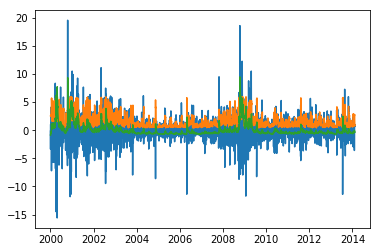

In [167]:
# Plot results
y1 = train_data_standard['return100']
y2 = pd.DataFrame(data=NN_obj.predict(), index = train_data_standard.index)
y3 = train_data_standard['garch']
plt.plot(y1)
plt.plot(y2)
plt.plot(y3)
plt.show()

In [169]:
# Compare Log-Likelihoods
print(
    f'''
    Calculations on training dataset
    Log_likelihood of average sigma : {lLik(obs_val=train_data[['return100']].to_numpy(), sigma_pred=np.sqrt(train_data[['var5_return100']].to_numpy())).sum()}
    Log_likelihood of Garch prediction : {lLik(obs_val=train_data[['return100']].to_numpy(), sigma_pred=np.sqrt(train_data[['garch']].to_numpy())).sum()} 
    Log_likelihood of NN prediction : {lLik(obs_val=train_data[['return100']].to_numpy(), sigma_pred=NN_obj.predict()).sum()}
    '''
)


    Calculations on training dataset
    Log_likelihood of average sigma : -6338.880172227772
    Log_likelihood of Garch prediction : -7110.505715097287 
    Log_likelihood of NN prediction : -6226.776787670995
    


### Results on Testing Dataset

In [181]:
# standardize all but first column where the returns are
test_data_standard = (
    test_data
        .drop('return100', axis=1)
        .apply(
            func=Standardizer_train.predict,
            axis=0,
            result_type='broadcast'
        )
        .join(test_data[['return100']])
)

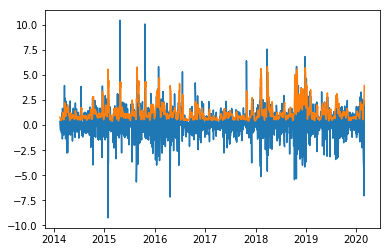

In [191]:
# Plot results
y1 = test_data_standard['return100']
y2 = pd.DataFrame(
        data=NN_obj.predict(new_input=test_data_standard.drop('return100', axis=1)), 
        index = test_data_standard.index
)
y3 = test_data_standard['garch']
plt.plot(y1)
plt.plot(y2)
# plt.plot(y3)
plt.show()

In [192]:
# Compare Log-Likelihoods
print(
    f'''
    Calculations on testing dataset
    Log_likelihood of average sigma : {lLik(obs_val=test_data[['return100']].to_numpy(), sigma_pred=np.sqrt(test_data[['var5_return100']].to_numpy())).sum()}
    Log_likelihood of Garch prediction : {lLik(obs_val=test_data[['return100']].to_numpy(), sigma_pred=np.sqrt(test_data[['garch']].to_numpy())).sum()} 
    Log_likelihood of NN prediction : {lLik(obs_val=test_data[['return100']].to_numpy(), sigma_pred=NN_obj.predict(new_input=test_data_standard.drop('return100', axis=1))).sum()}
    '''
)


    Calculations on training dataset
    Log_likelihood of average sigma : -2308.323036289985
    Log_likelihood of Garch prediction : -2655.5895981410513 
    Log_likelihood of NN prediction : -2244.7524368514087
    


# Old Stuff

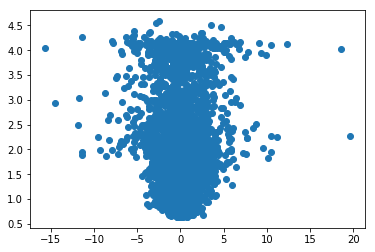

In [88]:
x = ret_data_enriched['return100']
y1 = NN_obj.get_output()
plt.scatter(x, y1)
# plt.plot(x, y2)
# plt.plot(x, y3)
# plt.plot(x, y4)
plt.show()

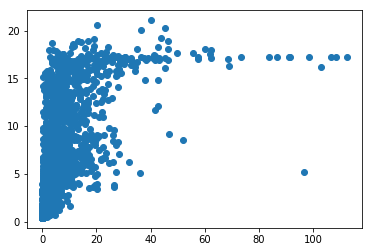

In [87]:
x = ret_data_enriched['var5_return100']
y1 = NN_obj.get_output()**2
plt.scatter(x, y1)
# plt.plot(x, y2)
# plt.plot(x, y3)
# plt.plot(x, y4)
plt.show()

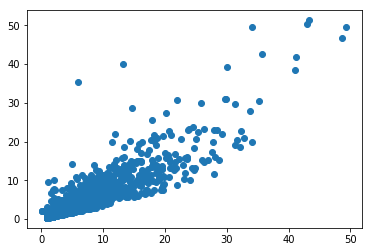

In [152]:
x = ret_data_enriched['garch']
y1 = NN_obj.get_output()
plt.scatter(x, y1)
# plt.plot(x, y2)
# plt.plot(x, y3)
# plt.plot(x, y4)
plt.show()

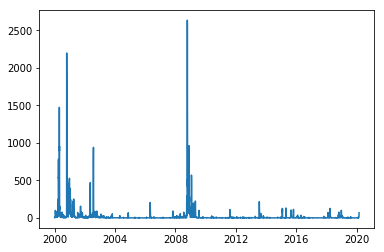

In [153]:
x = ret_data_enriched['dt']
y1 = ret_data_enriched['return100']
y2 = NN_obj.get_output() ** 2

plt.plot(x, y2)
plt.show()

In [41]:
NN_obj.get_weights()

[array([[ 1611837.73953872,   792260.24165044,  3004553.48070382,
          2317186.63723816,    26113.79160933],
        [ -636672.50907852,  -312940.81757742, -1186793.19034473,
          -915284.50135104,   -10314.20258629],
        [  218095.67899916,   107199.74056005,   406542.79422921,
           313535.79090393,     3534.01724127]]), array([[-386882.25280562],
        [ 250766.54755467],
        [ 354540.75900508],
        [-298564.0318481 ],
        [2000590.27145576]]), array([[1.]])]